Попытаемся внедрить быстрое сравнение круговых диаграмм в пайплайн сравнения круговых диаграмм вообще.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

# 1
from openstreetmap_load_data import find_objects_bounds, load_data_from_openstreetmap
from utils import calculate_right_top_coordinates
from google_api_load_data import load_prepare_and_cut_image
from osm_object import One_OSM_object, Image_OSM_object

# 2, 3
from circle_diagram import Image_circle_diagrams, Agent_circle_diagram
from circle_diagram import calculate_sectors_count, create_circle_diagram


**Формирование OSM-объекта остаётся таким же, здесь ничего не поменяется**

In [2]:
def load_all_image_info(left_bottom_lat, left_bottom_lon, data_path, image_path, load_from_net=False):
    right_top_lat, right_top_lon = calculate_right_top_coordinates(left_bottom_lat, left_bottom_lon)
    
    if load_from_net:
        load_data_from_openstreetmap(left_bottom_lat, left_bottom_lon, right_top_lat, right_top_lon, data_path)
        img_cutted_satellite = load_prepare_and_cut_image(left_bottom_lat=left_bottom_lat, left_bottom_lon=left_bottom_lon,
                                                      right_top_lat=right_top_lat, right_top_lon=right_top_lon,
                                                      is_debug=False)
        cv2.imwrite(image_path, img_cutted_satellite)
        
    bounds, tags = find_objects_bounds(data_path, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon)
    
    img_cutted_satellite = cv2.imread(image_path)
    
    return img_cutted_satellite, bounds, tags, right_top_lat, right_top_lon

In [3]:
left_bottom_lat = 54.3
left_bottom_lon = 48.6

img_cutted_satellite, bounds, tags, right_top_lat, right_top_lon = load_all_image_info(
    left_bottom_lat=left_bottom_lat, left_bottom_lon=left_bottom_lon,
    data_path="jsons/42.json", image_path="images/42.png")

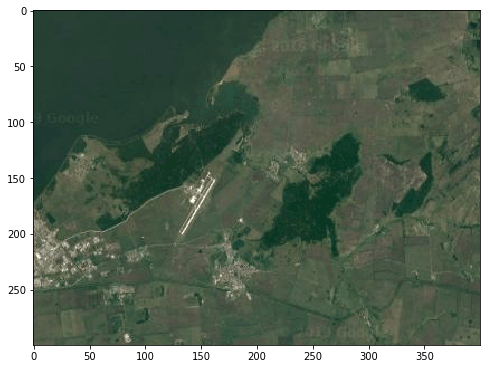

In [4]:
plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_cutted_satellite, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
img_osm = Image_OSM_object(
    img_cutted_satellite.shape,
    right_top_lat,
    right_top_lon,
    left_bottom_lat,
    left_bottom_lon,
    bounds,
    tags
)


In [6]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print(sectors_count)

616


Здесь в коде будет для каждой диаграммы создаваться 2 копии - обычная и быстрая.

In [7]:
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

In [8]:
print(len(img_cds.circle_diagrams))
print(len(img_cds.fast_diagrams))

48
48


Для диаграммы агента добавим новый метод - создание быстрой диаграммы.

In [9]:
agent_point = (250, 300)
agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
agent_cd.make_fast()
print(len(agent_cd.sectors))
# agent_cd.fast_diagram

616


**Теперь двумя способами будем считать штрафы и выбирать элемент сетки с наименьшим штрафом**

In [10]:
from diagram import Diagram

In [11]:
from circle_diagram import calculate_penalty_for_diagrams

In [12]:
%%time
print(img_cds.fast_diagrams[0].dist_to(agent_cd.fast_diagram))

501.0243225097656
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 9.66 ms


In [13]:
%%time
penalties = []
    
for i in range(len(img_cds.center_points)):
    img_cd = img_cds.circle_diagrams[i]

    cur_cd_penalties = []

    for j in range(len(agent_cd.sectors)):
        cur_cd_penalties.append(calculate_penalty_for_diagrams(img_cd.sectors, agent_cd.sectors))
        agent_cd.rotate()
    penalties.append(min(cur_cd_penalties))
    
    break

minimum_penalty = min(penalties)
print(minimum_penalty)

501.0220571028074
CPU times: user 692 ms, sys: 0 ns, total: 692 ms
Wall time: 691 ms


In [14]:
807 / 14.1

57.23404255319149

In [15]:
from circle_diagram import select_minimum_penalty_element_grid

In [16]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties1 = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=False)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(225.0, 325.0)]
[38]
CPU times: user 40.3 s, sys: 0 ns, total: 40.3 s
Wall time: 40.3 s


In [17]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties2 = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(225.0, 325.0)]
[38]
CPU times: user 480 ms, sys: 0 ns, total: 480 ms
Wall time: 480 ms


In [18]:
penalties1[19]

300.17753241807867

In [19]:
penalties2[19]

300.17926025390625

### Более мелкая сетка

In [20]:
bigger_side_blocks_count = 16
sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print(sectors_count)

2828


In [21]:
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

/media/ura/Windows/Users/ura-lenovo/ubuntu_mount/Diploma/utils.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


In [22]:
agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
agent_cd.make_fast()
print(len(agent_cd.sectors))

2828


In [23]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(187.5, 62.5)]
[114]
CPU times: user 26.9 s, sys: 28 ms, total: 27 s
Wall time: 26.9 s


In [24]:
print(len(penalties))

192


**Картинка.**

In [25]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

25.0
12.5


In [26]:
penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

(12, 16)


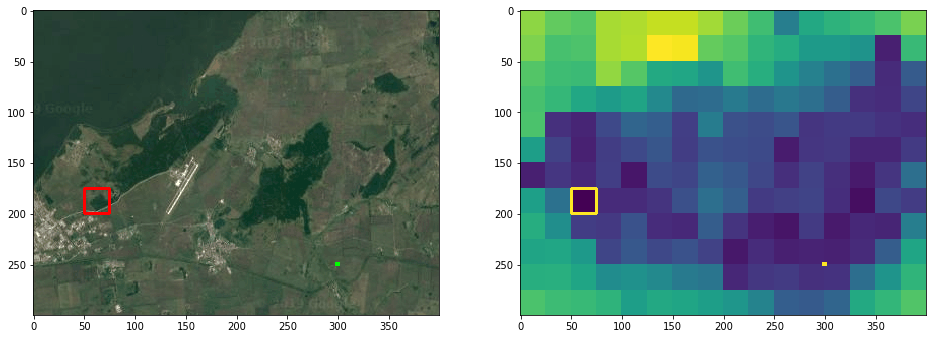

In [27]:
img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped, 25, axis=0), 25, axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

### Ещё более мелкая сетка

In [28]:
bigger_side_blocks_count = 20
sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print(sectors_count)

4537


In [29]:
%%time
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

/media/ura/Windows/Users/ura-lenovo/ubuntu_mount/Diploma/utils.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


CPU times: user 9.05 s, sys: 516 ms, total: 9.57 s
Wall time: 9.15 s


In [30]:
agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
agent_cd.make_fast()
print(len(agent_cd.sectors))

4537


In [31]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(250.0, 310.0)]
[255]
CPU times: user 1min 49s, sys: 112 ms, total: 1min 49s
Wall time: 1min 49s


In [32]:
print(len(penalties))

300


**И опять картинка**

In [33]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

20.0
10.0


In [34]:
penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

(15, 20)


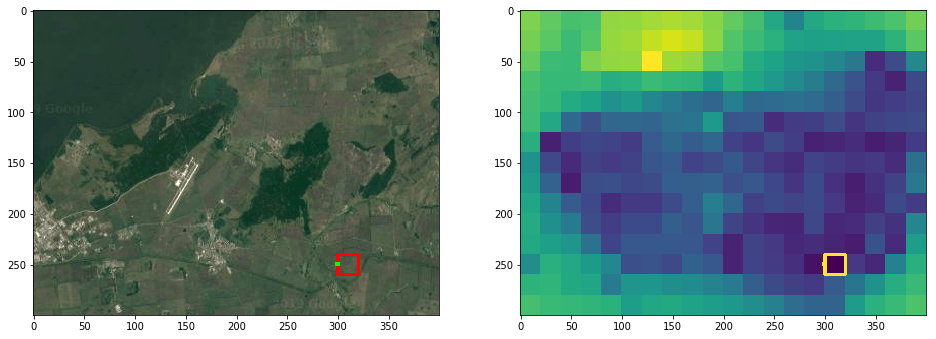

In [35]:
img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

### Ну и варианты с более крупной сеткой тоже тут запустим

In [36]:
bigger_side_blocks_count = 4
sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print(sectors_count)

img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
agent_cd.make_fast()
print(len(agent_cd.sectors))

114
114


/media/ura/Windows/Users/ura-lenovo/ubuntu_mount/Diploma/utils.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


In [37]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(250.0, 250.0)]
[10]
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.75 ms


In [38]:
print(len(penalties))

12


100.0
50.0
(3, 4)


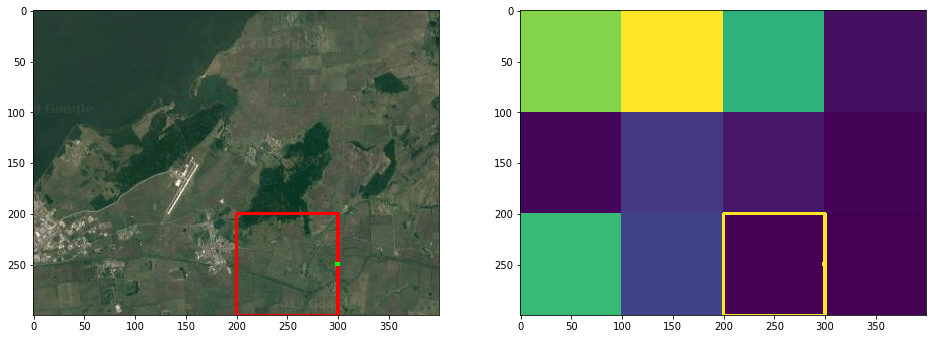

In [39]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

In [40]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print(sectors_count)

img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
agent_cd.make_fast()
print(len(agent_cd.sectors))

616
616


In [41]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(225.0, 325.0)]
[38]
CPU times: user 492 ms, sys: 0 ns, total: 492 ms
Wall time: 489 ms


In [42]:
print(len(penalties))

48


50.0
25.0
(6, 8)


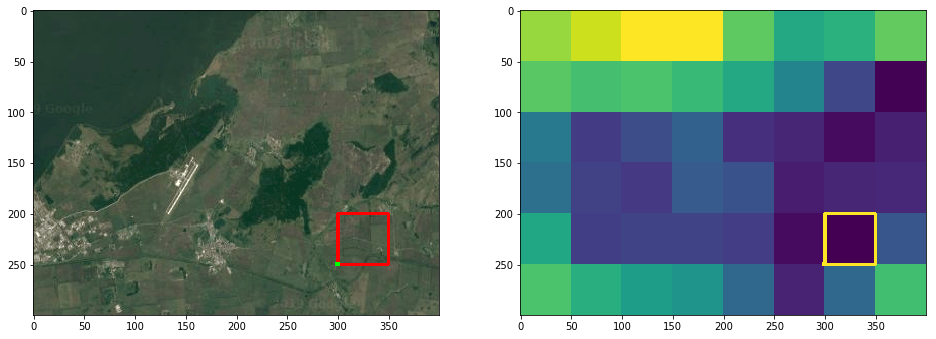

In [43]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()